# Fairness in Künstlicher Intelligenz
## Empirische Evaluierung
Dieses Notebook enthält einen möglichen Workflow für das Minimieren von Voreingenommenheiten in einem binären Klassifikator, der vorhersagen soll, ob das jährliche Einkommen einer Person 50.000$ übersteigen wird. Das zu entwickelnde Modell wird auf Voreingenommenheiten bezüglich des Geschlechtes untersucht. 

# Setup
Zuerst werden alle benötigten Module importiert. Zur Mitigation von Voreingenommenheit werden dazu in IBMs Open Source Bibliothek 'AI Fairness 360' (AIF360) implementierte Metriken und Methoden verwendet.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import seaborn as sns
import tensorflow as tf
from IPython.display import Markdown, display

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter

# AIF360 Bibliothek
import sys
sys.path.insert(1, "../")
import aif360
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"tensorflow: {tf.__version__}")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
sklearn: 0.24.1
pandas: 1.2.4
seaborn: 0.11.1
tensorflow: 2.5.0-rc1


In [2]:
# Setzen eines random seed um die Wiederholbarkeit der Versuche zu gewährleisten

seed = 123
np.random.seed(seed)

# Datensatz laden

In diesem Beispiel wird der Klassifikator anhand von US-amerikanischen Volkszählungsdaten aus dem Jahre 1994 trainiert. Der Datensatz, bekannt unter dem Namen 'Census Income Dataset' enthält sowohl numerische (z.B. 'age') als auch kategorische (z.B. 'workclass') Daten.
<br><br>
<i> Census Income Dataset: http://archive.ics.uci.edu/ml/datasets/Adult </i>

In [3]:
# Spaltennamen definieren und Datensatz einlesen

names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
    ]

data_raw = pd.read_csv('dataset/adult.data', names=names, sep=' *, *', na_values='?', engine = 'python')

In [4]:
# Die ersten fünf Einträge des Datensatzes anzeigen

data_raw.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Im Datensatz befinden zwei offensichtlich sensitive Attribute: 'sex' und 'race', eventuell könnte auch 'age' als sensitives Attribut gesehen werden. 
<br>
Dieser Versuch zielt nicht darauf ab, einen rundum fairen Klassifikator zu programmieren, sondern dient vielmehr als praktische Demonstration für die möglichen Ansätze zur AV-Erkennung und -Mitigation sowie deren Unterschiede, und beschränkt sich somit auf die Analyse und Erhöhung der Fairness des Klassifikators bezüglich eines der genannten sensitiven Attribute. Im folgenden Notebook wird die Fairness eines Klassifikators bezüglich des Attributs 'sex', dem Geschlecht der Person, untersucht. In der Entwicklung von später in Einsatz kommenden intelligenten Systemen sollten jedoch alle möglichen Diskriminierungen untersucht werden.

# Fehlende Daten entfernen
Zuerst werden die Daten bereinigt: Der Datensatz enthält unvollständige Einträge. Diese werden vor dem Training aus dem Datensatz entfernt. 

In [5]:
data = data_raw.copy()
print(f'Daten vor dem Entfernen: {data.shape}')
data.dropna(inplace=True)  # Alle Reihen, die 'NaN' (Not a Number) enthalten, werden entfernt
print(f'Daten nach dem Entfernen:: {data.shape}')

Daten vor dem Entfernen: (32561, 15)
Daten nach dem Entfernen:: (30162, 15)


# Datenanalyse + Visualisierungen
Bevor der Klassifikator trainiert wird, werden zunächst die verwendeten Daten untersucht. Können bereits im Datensatz Voreingenommenheiten erkannt werden?

### Ground Truth Balance

Klasse: <=50K, Anzahl: 22654, Prozent: 75.108%
Klasse: >50K, Anzahl: 7508, Prozent: 24.892%


[]

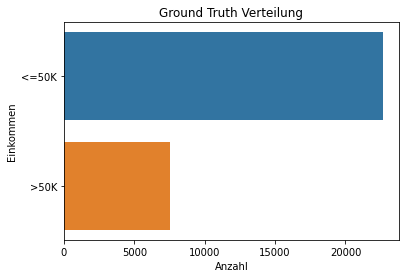

In [6]:
# Ausgeben der Balance zwischen positiven (>50K) und negativen (<=50K) Labels
income = data.values[:,-1]
counter_income = Counter(income)
for k,v in counter_income.items():
    per = v / len(income) * 100
    print('Klasse: %s, Anzahl: %d, Prozent: %.3f%%' % (k, v, per))
    
plt.figure()
sns.countplot(y='income', data=data)
plt.title('Ground Truth Verteilung')
plt.xlabel('Anzahl')
plt.ylabel('Einkommen')
plt.plot()

Die Verteilung zwischen positiven (>50K) und negativen (<=50K) Klassen ist in diesem Datensatz unausgeglichen. Ungleiche Repräsentation im verwendeten Datensatz kann ein frühzeitiges Anzeichen für spätere Voreingenommenheit gegenüber der stärker vertretenen Klasse (<=50K) sein, beispielsweise könnte die Fehlerrate in den Vorhersagen später zwischen den 'income' Klassen ebenso ungleich verteilt sein. Das Modell könnte außerdem durch das ständige Vorhersagen von '<=50K' bereits eine Klassifikationsgenauigkeit von 75% erzielen. 

### Ground Truth Verteilung nach dem sensitiven Attribut 'sex'

#### Ground Truth Verteilung nach dem sensitiven Attribut 'sex'

[]

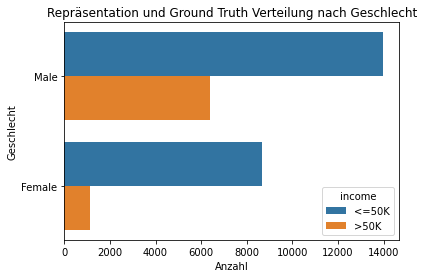

In [7]:
display(Markdown("#### Ground Truth Verteilung nach dem sensitiven Attribut 'sex'"))

plt.figure()
sns.countplot(y='sex', hue='income', data = data)
plt.title('Repräsentation und Ground Truth Verteilung nach Geschlecht')
plt.xlabel('Anzahl')
plt.ylabel('Geschlecht')
plt.plot()

Frauen sind gegenüber Männern unterrepräsentiert und weisen zusätzlich eine geringere Häufigkeit an positiven Labels (>50K) auf. Dies deutet auf eine Anfälligkeit auf Voreingenommenheit im späteren Modell hin. 
<br> 
In Verbindung mit der ungleichen Repräsentation der beiden 'income'-Klassen könnte es jedoch zum Beispiel auch möglich sein, dass die Fehlerrate in den Vorhersagen für Frauen, die aufgrund des voreingenommenen Datensatzes verhältnismäßig mehr in der 'income' Mehrheitsklasse vertreten sind, sogar geringer ausfällt als für Männer. 
<br>


### Vergleich: Ground Truth Verteilung nach dem sensitiven Attribut 'race'

#### Ground Truth Verteilung nach dem sensitiven Attribut 'race'

[]

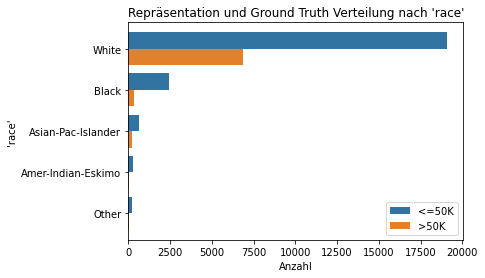

In [8]:
display(Markdown("#### Ground Truth Verteilung nach dem sensitiven Attribut 'race'"))
plt.figure()
sns.countplot(y='race', hue='income', data = data)
plt.title("Repräsentation und Ground Truth Verteilung nach 'race'")
plt.xlabel('Anzahl')
plt.ylabel("'race'")
plt.legend(loc='lower right')
plt.plot()

Der Datensatz enthält auch Informationen zu dem sensitiven Attribut "race". Mit der Verteilung dieses Attributs verhält es sich ähnlich wie mit dem Attribut "sex". Diese Visualisierung zeigt einerseits, dass der Wert "White" weit stärker repräsentiert ist als alle anderen Werte, andererseits ist auch der Anteil positiver Labels hier verhältnismäßig größer. Das ist somit ein starkes Anzeichen dafür, dass das Modell später bezüglich dieses Attributs voreingenommen werden kann. Wie bereits erwähnt, liegt der Fokus dieses Versuches auf dem sensitiven Attribut 'sex'. In der Entwicklung intelligenter Systeme sollte jedoch jedes sensitive Attribut auf Voreingenommenheit untersucht werden.

### Visualisierung der allgemeinen Verteilungen der numerischen Daten

In [9]:
# Numerische Daten extrahieren
num_data = data.select_dtypes(include=['int'])  
print(f'columns with numerical data: {num_data.columns}')

columns with numerical data: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

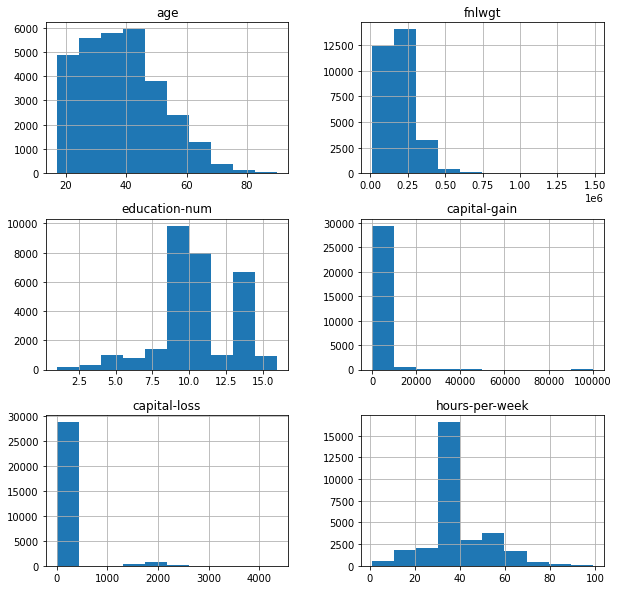

In [10]:
num_data.hist(figsize=(10,10))

Es kann beobachtet werden, dass auch die Verteilung des Alters nicht ausgeglichen ist. Das Modell könnte somit genauso auf Voreingenommenheiten gegenüber Personen über 50 untersucht werden, da diese Gruppe unterrepräsentiert ist. 
<br>
### Visualisierungen von Verteilungen nach dem Geschlecht
Neben den allgemeinen Verteilungen im Datensatz kann es für die frühzeitige Erkennung von Diskriminierung sowie dem Identifizieren von Proxyvariablen hilfreich sein, die Verteilungen in Bezug auf das sensitive Attribut zu analysieren.

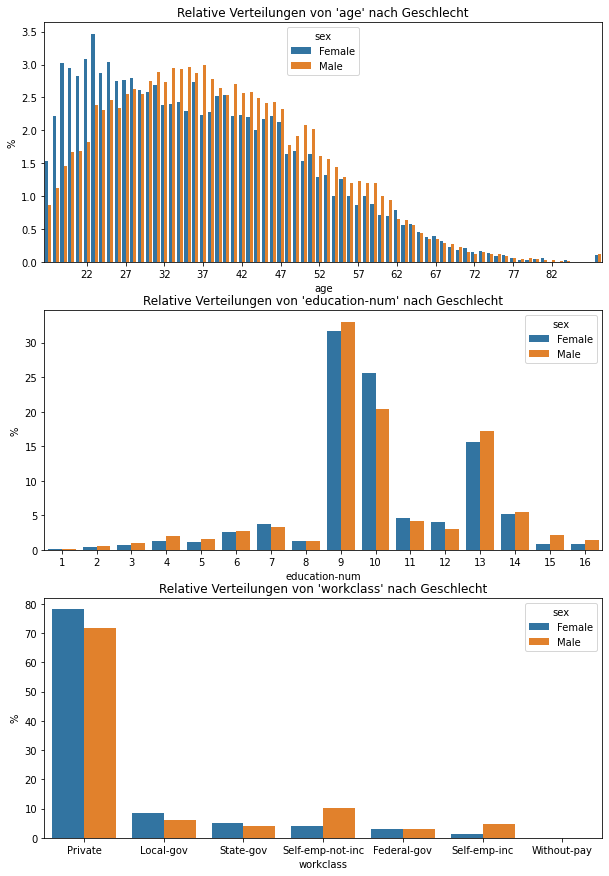

Mittlere Anzahl der Bildungsjahre, male:   10.132188420019627
Mittlere Anzahl der Bildungsjahre, female: 10.098650582702923
Durchschnittsalter, male:   39.18400392541707
Durchschnittsalter, female: 36.8834594152525


In [11]:
# Visualisieren der relativen Verteilungen von 'age', 'education-num' und 'workclass' nach Geschlecht

# Alter
age_sens_attr = (data.groupby(['sex'])['age']
                     .value_counts(normalize=True)
                     .rename('%')
                     .mul(100)
                     .reset_index())

# Bildungsjahre
educationnum_sens_attr = (data.groupby(['sex'])['education-num']
                     .value_counts(normalize=True)
                     .rename('%')
                     .mul(100)
                     .reset_index())
    
# Arbeitsklasse
workclass_sens_attr = (data.groupby(['sex'])['workclass']
                     .value_counts(normalize=True)
                     .rename('%')
                     .mul(100)
                     .reset_index())

fig, ax = plt.subplots(3,1, figsize=(10,15))

sns.barplot(ax=ax[0], x="age", y="%", data=age_sens_attr, hue="sex")
ax[0].set_xticks([5,10,15,20,25,30,35,40,45,50,55,60,65])
ax[0].set_title("Relative Verteilungen von 'age' nach Geschlecht")

sns.barplot(ax=ax[1], x="education-num", y="%", data=educationnum_sens_attr, hue="sex")
ax[1].set_title("Relative Verteilungen von 'education-num' nach Geschlecht")

sns.barplot(ax=ax[2], x="workclass", y="%", data=workclass_sens_attr, hue="sex")
ax[2].set_title("Relative Verteilungen von 'workclass' nach Geschlecht") 

plt.show()


# Berechnen der Durchschnittswerte für 'age' und 'education-num' nach Geschlecht
males_in_data = data[data['sex'] == 'Male']
females_in_data = data[data['sex'] == 'Female']

print(f'Mittlere Anzahl der Bildungsjahre, male:   {males_in_data["education-num"].mean()}')
print(f'Mittlere Anzahl der Bildungsjahre, female: {females_in_data["education-num"].mean()}')

print(f'Durchschnittsalter, male:   {males_in_data["age"].mean()}')
print(f'Durchschnittsalter, female: {females_in_data["age"].mean()}')

Während sich die relativen Verteilungen von Alter, Anzahl der Bildungsjahre und Arbeitsfeld prinzipiell zwischen beiden Geschlechtern überschneiden, sind doch Unterschiede erkennbar, so sind Frauen im Datensatz z.B. durchschnittlich jünger. Auch die Verteilung der Bildungsjahre unterscheidet sich etwas, die Jahresanzahl für Männer hat in diesem Datensatz etwa eine höhere Wahrscheinlichkeit, 12 Jahre zu übersteigen. Außerdem ist es in diesen Daten für Männer häufiger der Fall, mit ihrem Job selbstständig zu sein. Muster wie diese bedeuten, dass diese Variablen auch indirekte Informationen über das sensitive Attribut beinhalten, die das Modell aufschnappen könnte.

In weiterer Folge werden Voreingenommenheiten und Diskriminierungen bezogen auf das sensitive Attribute 'sex' näher untersucht. Zunächst wird dazu ein Baseline Modell mit den unveränderten Daten trainiert, um es später nach der Anwendung von Methoden zur Minimierung von Voreingenommenheiten als Referenz heranziehen zu können. 

# Trainieren des voreingenommenen Baseline Modells

## Daten formatieren
### Numerischen Datensatz erstellen
Der verwendete Datensatz enthält sowohl numerische als auch kategorische Daten. Die numerischen werden standardisiert, da sie unterschiedliche Skalen aufweisen, die kategorischen werden in numerische Daten umgewandelt. 

In [12]:
# Erstellen des numerischen Datensatzes
data_num = data.copy()

# Die Attribute 'income' und 'sex' werden in integers (0 oder 1) umgewandelt, da sie nur einen von zwei Werten annehmen können 
data_num['income'] = (data_num['income'] == '>50K').astype(int)  # Werte für 'income' '>50' werden nun durch '1' repräsentiert
data_num['sex'] = (data_num['sex'] == 'Male').astype(int)  # Werte für 'Male' werden nun durch '1' repräsentiert

# Die Methode pd.get_dummies() transformiert die kategorischen Spalten in numerische
data_num = data_num.fillna('Unknown').pipe(pd.get_dummies, drop_first=True)

In [13]:
print(f'Der Datensatz hat nun {data_num.shape[0]} Einträge mit {data_num.shape[1]} Spalten.')
data_num.head()

Der Datensatz hat nun 30162 Einträge mit 97 Spalten.


,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,1,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,1,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,1,0,0,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,1,0,0,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# data_num.info()  # Gibt detailiertere Informationen zu jeder Spalte

### Standardisieren folgender numerischen Spalten: 
- age
- fnlwgt
- education-num
- capital-gain
- capital-loss
- hours-per-week

In [15]:
# Liste der Namen der betroffenen Spalten
columns_std = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']  

In [16]:
# Standardisieren dieser Spalten mittels 'Column Transformer'
ct = ColumnTransformer([('transformer', StandardScaler(), columns_std)], remainder='passthrough')
data_num_copy = data_num.copy()
new_columns = list(data_num_copy.columns)
features = data_num_copy[new_columns]
data_num_st_ar = ct.fit_transform(features)
data_num_st_ar.shape

(30162, 97)

'Column Transformer' gibt ein numpy array mit veränderter Reihung der Spalten zurück: Die transformierten (standardisierten) Spalten befinden sich nun am Beginn des arrays. Bevor das array wieder in einen Dataframe zurückgewandelt wird, muss somit die Reihung der Spaltennamen angepasst werden. 

In [17]:
columns_rearranged = list(data_num_copy.columns)
columns_rearranged.remove('sex')  # Das Attribut 'sex' muss nach hinten gereiht werden 
insert_index = columns_rearranged.index(columns_std[-1])+1  # Index nach der letzten transformierten Spalte (6)
columns_rearranged.insert(insert_index, 'sex')
final_data = pd.DataFrame(data=data_num_st_ar, columns=columns_rearranged)
final_data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,sex,income,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.042796,-1.062722,1.128918,0.146092,-0.218586,-0.077734,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.880288,-1.007871,1.128918,-0.147445,-0.218586,-2.331531,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.033340,0.244693,-0.439738,-0.147445,-0.218586,-0.077734,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.108695,0.425240,-1.224066,-0.147445,-0.218586,-0.077734,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.794697,1.406658,1.128918,-0.147445,-0.218586,-0.077734,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Vor dem Training wird hier nochmal überprüft, ob sich in den finalen Daten keine NaN Werte mehr befinden
nan_error = False
for column in final_data:
    if final_data[column].isnull().values.any():
        nan_error = True
        print('Encountered NaN in column ' + column)
if not nan_error: 
    print('OK - No NaN values.')

OK - No NaN values.


### Teilen der Daten für Training und Testing
Zum Trainieren des Modells werden die Labels ('income') aus den Daten separiert. Außerdem wird der Datensatz in Training und Testdaten geteilt.

In [19]:
X = final_data.drop(columns=['income'])
y = final_data['income']

In [20]:
# 70% Training, 30% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (21113, 96)
y_train: (21113,)
X_test: (9049, 96)
y_test: (9049,)


# Trainieren des voreingenommenen Baseline Modells

Für den Klassifikator wird ein einfaches logistisches Regressionsmodell verwendet, da der Fokus dieses Versuches auf dem Erkennen und Vermeiden von algorithmischer Voreingenommenheit liegt.

In [22]:
model_baseline = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)  
model_baseline.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [23]:
# Vorhersagen der Testdaten
predicted_classes = model_baseline.predict(X_test)

In [24]:
accuracy_score(predicted_classes, y_test)

0.8511437727925738

Der Klassifikator erreicht eine Genauigkeit von etwa 85,1%. Aber wie sieht es mit der Fairness aus?

# Fairness Metriken

## Disparate Impact & Statistical Parity

Fairnessmetriken wie diese werden anhand der Ergebnisverteilung und/oder deren Richtigkeit bezogen auf die Ground Truth berechnet und können je nach Bedarf selbst implementiert werden. Zwei Metriken werden hier beispielhaft selbst implementiert, später werden auch implementierte Metriken der AIF360 Bibliothek verwendet. <br> 
Zuerst wird die Disparate Impact Metrik und die Statistical Parity Metrik für den ursprünglichen Datensatz berechnet, welche sich beide auf die Verteilung der positiven Resultate für beide Gruppen beziehen. Die Statistical Parity Metrik beschreibt die Differenz der Raten aller positiven Resultate der geschützten Gruppe zu jener der privilegierten und ist bei einem Wert von 1 fair. Die Disparate Impact Metrik beschreibt das Verhältnis der Raten und gilt bei einem Ergebnis von 0 als fair. Da beide Metriken auf der Positiv-Rate basieren, wurde zuerst eine Methode implementiert, die diese Raten (relativer Anteil der positiven '>50K' Labels einer Gruppe) für Frauen als auch für Männer aus den Daten, der Ground Truth und dem angegebenen sensitiven Attribut berechnet:

In [25]:
# Methode, die die Rate der positiven Labels (>50K) zurückgibt

def get_p_ratios(X, sens_attr, y):
    # Dataframe mit allen Einträgen mit sensitivem Attribut "Male"
    data_males = X[X[sens_attr] == 1.0]
    data_males_num = data_males.shape[0]
    
    # Dataframe mit allen Einträgen mit sensitivem Attribut "Female"
    data_females = X[X[sens_attr] == 0.0]
    data_females_num = data_females.shape[0]
    
    # Überprüfen ob die berechneten Zahlen mit dem ursprünglichen Datensatz übereinstimmen
    if (data_males_num + data_females_num) != X.shape[0]:
        print('ERROR: Datenanzahl stimmt nicht mit dem Datensatz überein')
        
    # Positiv-Raten berechnen
    y_male = y[X[sens_attr] == 1.0]
    y_female = y[X[sens_attr] == 0.0]
       
    # 'Male'
    male_outcomes = data_males[y_male == 1.0].shape[0]  # Anzahl der positiven Labels
    male_p_ratio = male_outcomes/data_males_num  # Positiv-Rate
 
    # 'Female'
    female_outcomes = data_females[y_female == 1.0].shape[0]  # Anzahl der positiven Labels
    female_p_ratio = female_outcomes/data_females_num  # Positiv-Rate

    return male_p_ratio, female_p_ratio 

Die Methoden zur Disparate Impact und Statistical Parity Metrik rufen get_p_ratio() auf und verrechnen deren Ergebnisse auf unterschiedliche Weise:

In [26]:
def disparate_impact(X, sens_attr, y):

    male_p_ratio, female_p_ratio = get_p_ratios(X, sens_attr, y) 
        
    disparate_impact_ratio = female_p_ratio/male_p_ratio 
 
    return disparate_impact_ratio

In [27]:
def statistical_parity_difference(X, sens_attr, y):

    male_p_ratio, female_p_ratio = get_p_ratios(X, sens_attr, y)  
    
    statistical_parity_difference = female_p_ratio - male_p_ratio 
  
    return statistical_parity_difference

### Evaluierung: AV im Datensatz und Baseline Modell

Nun können beide Metriken für den ursprünglichen Datensatz, sowie für die Vorhersagen des Modells berechnet und visualisiert werden:

In [28]:
# Unterschiede für positive Ergebnisse für geschützte und privilegierte Gruppe

disparate_impact_baseline_dataset = disparate_impact(X_train, 'sex', y_train)
statistical_parity_baseline_dataset = statistical_parity_difference(X_train, 'sex', y_train)
disparate_impact_baseline_model = disparate_impact(X_test, 'sex', predicted_classes)
statistical_parity_baseline_model = statistical_parity_difference(X_test, 'sex', predicted_classes)


display(Markdown("#### Fairness des originalen Datensatzes"))
print(f"Disparate Impact:               {str(disparate_impact_baseline_dataset)}") 
print(f"Statistical Parity Difference: {str(statistical_parity_baseline_dataset)}")
 
display(Markdown("#### Fairness des Baseline Modells"))
print(f"Disparate Impact:               {str(disparate_impact_baseline_model)}")
print(f"Statistical Parity Difference: {str(statistical_parity_baseline_model)}")

#### Fairness des originalen Datensatzes

Disparate Impact:               0.3636437914754868
Statistical Parity Difference: -0.19865466248420066


#### Fairness des Baseline Modells

Disparate Impact:               0.2995328708058701
Statistical Parity Difference: -0.1831622258645452


In [29]:
# Visualisierungen der Metriken

def plot_metric(metricname, metricvalue, ax):
    
    ax.bar(metricname, metricvalue, color='grey')
    ax.set_ylabel('fair', loc='center', rotation=0)
    
    if metricname == 'fnrr':
        ax.axhspan(1, 2, facecolor='red', alpha=0.06)
        ax.yaxis.set_label_coords(1.1, 0.48)
        ax.axhline(1, color='grey', linewidth=0.8)
        ax.set_ylim(0,2)
    elif metricname == 'disp_imp' or metricname == 'fprr':
        ax.yaxis.set_label_coords(1.1, 0.48)
        ax.axhline(1, color='grey', linewidth=0.8)
        ax.set_ylim(0,2)
        ax.axhspan(0, 1, facecolor='red', alpha=0.06)
    elif metricname == 'stat_par_diff' or metricname == 'fnrr' or metricname == 'avg_odds_diff' or metricname == 'eq_opp_diff':
        ax.yaxis.set_label_coords(1.1, 0.48)
        ax.axhline(0, color='grey', linewidth=0.8)
        ax.set_ylim(-1,1)
        ax.axhspan(-1, 0, facecolor='red', alpha=0.06)
    elif metricname == 'theil_ind':
        ax.yaxis.set_label_coords(1.1, -0.02)
        ax.axhline(0, color='grey', linewidth=0.8)
        ax.set_ylim(0,2)
    elif metricname == 'err_r_diff':
        ax.yaxis.set_label_coords(1.1, 0.48)
        ax.axhline(0, color='grey', linewidth=0.8)
        ax.set_ylim(-1,1)
        ax.axhspan(0, 1.5, facecolor='red', alpha=0.06)
    
    ax.bar(metricname, metricvalue, color='grey')
    #red_patch = mpatches.Patch(color='red', alpha=0.1, label='voreingenommen')
    #ax.legend(handles=[red_patch])

### Disparate Impact und Statistical Parity

#### Datensatz (links) - Vorhersagen des Modells (rechts)

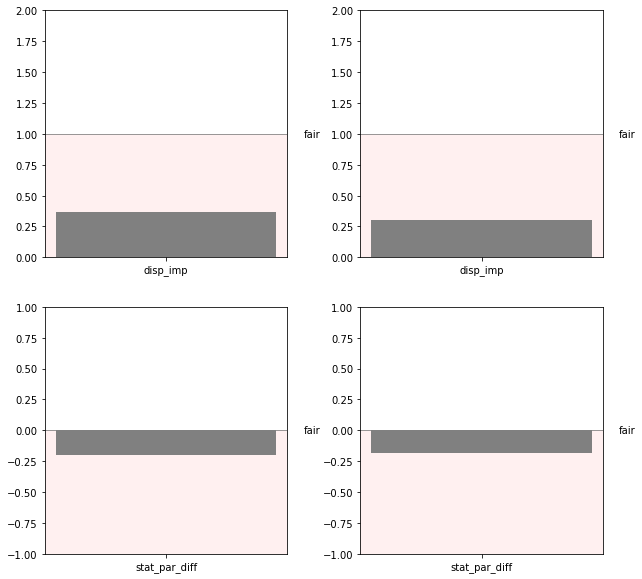

In [30]:
display(Markdown("### Disparate Impact und Statistical Parity"))
display(Markdown("#### Datensatz (links) - Vorhersagen des Modells (rechts)"))

fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

plot_metric('disp_imp', disparate_impact_baseline_dataset, ax[0,0])
plot_metric('disp_imp', disparate_impact_baseline_model, ax[0,1])

plot_metric('stat_par_diff', statistical_parity_baseline_dataset, ax[1,0])
plot_metric('stat_par_diff', statistical_parity_baseline_model, ax[1,1])

plt.show()

Laut den Ergebnissen der beiden Metriken erreicht der Klassifikator keine algorithmische Fairness. Schon der Datensatz weist Voreingenommenheiten auf, die Disparate Impact Metrik erreicht gar nur einen Wert von ca. 0,36, wobei ein Wert von 1 wünschenswert wäre. Das bedeutet, dass Männer 2,8-mal (1/0,36) so oft ein positives Ergebnis im Datensatz aufweisen wie Frauen. Im Modell wurde dieser Effekt verstärkt, mit einem Disparate Impact Wert von etwa 0,3 wird Männern nach dem Training 3,3-mal so oft ein hohes Einkommen zugeschrieben wie Frauen. <br>
Was zunächst vielleicht verwunderlich erscheint: Wieso wird die Statistical Parity Metrik kleiner, d.h. "fairer", wenn das Modell laut Disparate Impact Metrik "unfairer" wird? Dieser Effekt zeigt, dass es nicht möglich ist, einen Klassifikator als allgemein "fair" oder "unfair" zu definieren, es kommt immer auf die Wahl der Metrik an, anhand welcher die Fairness gemessen wird. Die Disparate Impact Metrik gibt das Verhältnis der Positiv-Raten an, die Statistical Parity Metrik die Differenz. Relativ gesehen unterschieden sich die Raten der Modell-Vorhersagen mehr als zuvor, weshalb das Modell laut Disparate Impact Metrik "unfairer" wird. Insgesamt sinken jedoch die Positiv-Raten für beide Gruppen etwas, weshalb der absolute Unterschied ebenfalls sinkt und das Modell laut Statistical Parity Metrik "fairer" wird. Je nach Anwendungsfall, und vor allem späteren Einsatzbereich des Modells, müssen daher Metriken favorisiert werden. Ein Erreichen eines perfekten Fairnesswertes ist dabei generell sehr schwierig. Es ist daher üblich, einen Mindestwert zu definieren, der pro Metrik erreicht werden sollte. Die Mindestwerte der verwendeten Metriken hängen vom individuell gesetzten Ziel für die Fairness des Klassifikators ab. Dient der Klassifikator z.B. der Evaluierung von Bewerber*innen eines Kredites, kann algorithmische Voreingenommenheit direkte, allokative Schäden bedeuten, was weniger Spielraum für die Ergebnisse der Fairnessmetriken lässt.


## Weitere Metriken zur Evaluierung des Modells

Ähnlich der beschriebenen Vorgehensweise können je nach Anforderungen des Modells beliebige Fairnessmetriken selbst definiert und angewendet werden. Aber auch verschiedene Open Source Bibliotheken stellen eine Vielzahl an bereits vordefinierten und implementierten Metriken zur Verfügung. In diesem Versuch werden einige weitere Metriken der AI Fairness 360 Bibliothek zur Messung der AV in den Vorhersagen des Modells evaluiert. Die verwendeten Metriken basieren nicht nur auf dem Verhältnis der positiven Ergebnisse, sondern auch auf Werten zu den True/False Positives/Negatives, individueller Fairness sowie Fehlerraten. 
<br> 
Die AIF360 Bibliothek setzt zunächst das Transformieren des Datensatzes in einen eigenes "BinaryLabelDataset" voraus.

### Umwandeln des Datensatzes in ein AIF360 BinaryLabelDataset

In [31]:
# Umwandeln der Trainingsdaten
# BinaryLabelDatasets beinhalten die Attribute sowie die zugehörigen Labels 
data_aif_train = pd.concat([X_train, y_train], axis=1)

X_aif_train = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,  # Positives Label für 'income'
    unfavorable_label=0,  # Negatives Label für 'income'
    df=data_aif_train,  # Attribute
    label_names=['income'],  # Name der Label-Spalte 
    protected_attribute_names=['sex'])  # Name des betrachteten sensitiven Attributes

# Umwandeln der Testdaten
data_aif_test = pd.concat([X_test, y_test], axis=1)

X_aif_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=data_aif_test,
    label_names=['income'],
    protected_attribute_names=['sex'])

In [32]:
# Methode zum Beschreiben der BinaryLabelDatasets

def describe_data(traindata=None, valdata=None, testdata=None):
    
    if traindata is not None:
        display(Markdown("#### Training Datensatz: .shape"))
        print(traindata.features.shape)
        
    if valdata is not None:
        display(Markdown("#### Validation Datensatz: .shape"))
        print(valdata.features.shape)
        
    display(Markdown("#### Testing Datensatz: .shape"))
    print(testdata.features.shape)
    
    display(Markdown("#### Positives und Negatives Label"))
    print(testdata.favorable_label, testdata.unfavorable_label)
    
    display(Markdown("#### Sensitives Attribut, privilegiert und geschützt"))
    print(testdata.protected_attribute_names, testdata.privileged_protected_attributes, testdata.unprivileged_protected_attributes)
        
    display(Markdown("#### Spaltennamen"))
    print(testdata.feature_names)

In [33]:
# Ausgeben einiger Informationen zu den Datensätzen
describe_data(traindata = X_aif_train, testdata = X_aif_test)

#### Training Datensatz: .shape

(21113, 96)


#### Testing Datensatz: .shape

(9049, 96)


#### Positives und Negatives Label

1.0 0.0


#### Sensitives Attribut, privilegiert und geschützt

['sex'] [array([1.])] [array([0.])]


#### Spaltennamen

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct', 'occupation_Other-service', 'occupation_Priv-house-serv', 

### Anwenden der AIF360 Fairnessmetriken auf die Vorhersagen des Modells
Im Folgenden werden einige Metriken der AIF360 Bibliothek zur Evaluierung der Fairness herangezogen. Verwendet werden:
- <b> Accuracy: </b> Klassifikationsgenauigkeit
- <b> Disparate Impact: </b> Implementierung der zuvor selbst geschriebenen Metrik zum Verhältnis der Positiv-Raten
- <b> False Negative Rate Ratio: </b> Verhältnis der zu Unrecht negativ klassifizierten Fälle beider Gruppen
- <b> False Positive Rate Ratio: </b> Verhältnis der zu Unrecht positiv klassifizierten Fälle beider Gruppen
- <b> Statistical Parity Difference: </b> Implementierung der zuvor selbst geschriebenen Metrik zur Differenz der Positiv-Raten
- <b> Average Odds Difference: </b> Durchschnittliche Differenz in False Positive (zu Unrecht positiv) und True Positive (zu Recht positiv) Raten beider Gruppen
- <b> Equal Opportunity Difference: </b> Differenz der True Positive (zu Recht positiv) Raten zwischen beiden Gruppen
- <b> Theil Index: </b> gibt an, wie stark Ungleichheiten in den Resultaten von Unterschieden zwischen Einzelpersonen zwischen den Gruppen abhängen
- <b> Error Rate Difference: </b> Unterschied in den Raten falsch klassifizierter Fälle beider Gruppen

In [34]:
privileged_group = [{'sex': 1}]
unprivileged_group = [{'sex': 0}]

In [35]:
# Methode zum Berechnen der AIF360 Metriken

def get_aif_metrics(X_aif_test, predictions):

    metrics = {}

    # Erstellen eines BinaryLabelDataset mit den Modellvorhersagen als Labels
    data_pred = X_aif_test.copy()
    data_pred.labels = predictions

    metric = ClassificationMetric(  # ClassificationMetric berechnet Metriken basierend auf den vorhergesagten Resultaten und der Ground Truth
            X_aif_test, data_pred,
            unprivileged_groups=unprivileged_group,
            privileged_groups=privileged_group)
    
    # Metriken mit optimalem Ergebnis = 1
    metrics['acc'] = (metric.accuracy()) 

    metrics['disp_imp'] = (metric.disparate_impact())  # Wertebereich: -1 bis 1; disp_imp < 1: Nachteil für geschützte Gruppe
    metrics['fprr'] = (metric.false_positive_rate_ratio())  # Wertebereich; 0+; FPRR < 1: Nachteil für geschützte Gruppe
    metrics['fnrr'] = (metric.false_negative_rate_ratio())  # Wertebereich: 0+; FNRR > 1: Nachteil für geschützte Gruppe

    # Metriken mit optimalem Ergebnis = 0
    metrics['stat_par_diff'] = (metric.statistical_parity_difference())  # Wertebereich: -1 bis 1; stat_par_diff < 0: Nachteil für geschützte Gruppe  
    metrics['avg_odds_diff'] = (metric.average_odds_difference())  # Wertebereich: -1 bis 1; avg_odds_diff < 0: Nachteil für geschützte Gruppe 
    metrics['eq_opp_diff'] = (metric.equal_opportunity_difference())  # Wertebereich: -1 bis 1; eq_opp_diff < 0: Nachteil für geschützte Gruppe 
    metrics['theil_ind'] = (metric.theil_index())  # Wertebereich: 0+; theil_ind > 0: Ungleichheit in der Leistungsverteilung für Individuen  
    metrics['err_r_diff'] = (metric.error_rate_difference())  # Wertebereich: -1 bis 1; err_r_dif > 0: Nachteil für geschützte Gruppe 
    return metrics

In [36]:
# Methode zum Ausgeben der AIF360 Metriken

def describe_aif_metrics(metrics):

    print("Accuracy:                              {:6.2f}%".format((metrics['acc'])*100))
    print("Disparate Impact:                        {:6.4f}".format(metrics['disp_imp']))
    print("False Positive Rate Ratio:               {:6.4f}".format(metrics['fprr'])) 
    print("False Negative Rate Ratio:               {:6.4f}".format(metrics['fnrr']))  
    
    print("Statistical Parity Difference:          {:6.4f}".format(metrics['stat_par_diff']))
    print("Equalized/Average odds difference:      {:6.4f}".format(metrics['avg_odds_diff']))
    print("Equal opportunity difference:           {:6.4f}".format(metrics['eq_opp_diff']))
    print("Theil index:                             {:6.4f}".format(metrics['theil_ind']))
    print("Error Rate Difference:                  {:6.4f}".format(metrics['err_r_diff']))  
   

In [37]:
# Methode zum Visualisieren der Metrik-Ergebnisse des Baselinemodells als Scatterplot

def plot_aif_metrics(aif_metrics_baseline):
    
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,3,5]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    
    x_coord = 0
    for metric in aif_metrics_baseline:
        if metric == 'acc':
            ax0.scatter(metric, aif_metrics_baseline[metric], label="before mitigation", color = "black")
        elif metric == 'disp_imp' or metric == 'fnrr' or metric == 'fprr':
            ax1.scatter(metric, aif_metrics_baseline[metric], label="before mitigation", color = "darkgreen")
        else: 
            ax2.scatter(metric, aif_metrics_baseline[metric], label="before mitigation", color = "darkblue")
        x_coord += 1
   
    ax0.set_ylim(0,1)
    ax0.set_title('Genauigkeit')
    ax0.set_yticks(np.arange(0, 1, step=0.1))
    ax0.axhspan(0, 0.75, 0, 1, facecolor='red', alpha=0.02)
    ax0.axhspan(0.75, 1, 0, 1, facecolor='green', alpha=0.05)
    black_patch = mpatches.Patch(color='black', label='acc')
    ax0.legend(handles=[black_patch], loc='lower left')
    
    ax1.set_ylim(0, 2)
    ax1.set_title('Fairness = 1')
    ax1.set_yticks(np.arange(0, 2, step=0.2))
    ax1.hlines(1, -0.5, 2.5, color='green', linewidth=0.8)
    ax1.axhspan(0, 1, 0, 0.7, facecolor='red', alpha=0.02)
    ax1.axhspan(1, 2, 0, 0.7, facecolor='green', alpha=0.05)
    ax1.axhspan(1, 2, 0.7, 1, facecolor='red', alpha=0.02)
    ax1.axhspan(0, 1, 0.7, 1, facecolor='green', alpha=0.05)
    darkgreen_patch = mpatches.Patch(color='darkgreen', label='baseline')
    ax1.legend(handles=[darkgreen_patch])
    
    ax2.set_ylim(-1,1)
    ax2.set_title('Fairness = 0')
    ax2.set_yticks(np.arange(-1, 1, step=0.2))
    ax2.hlines(0, -0.5, 4.5, color='blue', linewidth=0.8)
    ax2.axhspan(-1, 0, 0, 0.55, facecolor='red', alpha=0.02)
    ax2.axhspan(0, 1, 0, 0.55, facecolor='green', alpha=0.05)
    ax2.axhspan(0, 1, 0.55, 1, facecolor='red', alpha=0.02)
    ax2.axhspan(-1, 0, 0.55, 1, facecolor='green', alpha=0.05)
    darkblue_patch = mpatches.Patch(color='darkblue', label='baseline')
    ax2.legend(handles=[darkblue_patch])

    plt.show()

In [38]:
# Methode zum späteren vergleichenden Visualisieren der Fairnessergebnisse des Baseline Modells mit dem Modell nach dem Anwenden von AV-Mitigationsmethoden

def compare_models(aif_metrics_baseline, aif_metrics_mitigated):
    
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,3,5]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    
    x_coord = 0
    for metric in aif_metrics_baseline:
        if metric == 'acc':
            ax0.scatter(metric, aif_metrics_baseline[metric], label="before mitigation", color = "black")
            ax0.scatter(metric, aif_metrics_mitigated[metric], label="after mitigation", color = "grey")
        elif metric == 'disp_imp' or metric == 'fnrr' or metric == 'fprr':
            ax1.scatter(metric, aif_metrics_baseline[metric], label="before mitigation", color = "darkgreen")
            ax1.scatter(metric, aif_metrics_mitigated[metric], label="after mitigation", color = "lightgreen")
        else: 
            ax2.scatter(metric, aif_metrics_baseline[metric], label="before mitigation", color = "darkblue")
            ax2.scatter(metric, aif_metrics_mitigated[metric], label="after mitigation", color = "lightblue")
        x_coord += 1
   
    ax0.set_ylim(0,1)
    ax0.set_title('Genauigkeit')
    ax0.set_yticks(np.arange(0, 1, step=0.1))
    ax0.axhspan(0, 0.75, 0, 1, facecolor='red', alpha=0.02)
    ax0.axhspan(0.75, 1, 0, 1, facecolor='green', alpha=0.05)
    black_patch = mpatches.Patch(color='black', label='acc')
    grey_patch = mpatches.Patch(color='grey', label='acc neu')
    ax0.legend(handles=[black_patch, grey_patch], loc='lower left')
    
    ax1.set_ylim(0, 2)
    ax1.set_title('Fairness = 1')
    ax1.set_yticks(np.arange(0, 2, step=0.2))
    ax1.hlines(1, -0.5, 2.5, color='green', linewidth=0.8)
    ax1.axhspan(0, 1, 0, 0.7, facecolor='red', alpha=0.02)
    ax1.axhspan(1, 2, 0, 0.7, facecolor='green', alpha=0.05)
    ax1.axhspan(1, 2, 0.7, 1, facecolor='red', alpha=0.02)
    ax1.axhspan(0, 1, 0.7, 1, facecolor='green', alpha=0.05)
    darkgreen_patch = mpatches.Patch(color='darkgreen', label='baseline')
    lightgreen_patch = mpatches.Patch(color='lightgreen', label='AV reduziert')
    ax1.legend(handles=[darkgreen_patch, lightgreen_patch])
    
    ax2.set_ylim(-1,1)
    ax2.set_title('Fairness = 0')
    ax2.set_yticks(np.arange(-1, 1, step=0.2))
    ax2.hlines(0, -0.5, 4.5, color='blue', linewidth=0.8)
    ax2.axhspan(-1, 0, 0, 0.55, facecolor='red', alpha=0.02)
    ax2.axhspan(0, 1, 0, 0.55, facecolor='green', alpha=0.05)
    ax2.axhspan(0, 1, 0.55, 1, facecolor='red', alpha=0.02)
    ax2.axhspan(-1, 0, 0.55, 1, facecolor='green', alpha=0.05)
    darkblue_patch = mpatches.Patch(color='darkblue', label='baseline')
    lightblue_patch = mpatches.Patch(color='lightblue', label='AV reduziert')
    ax2.legend(handles=[darkblue_patch, lightblue_patch])

    plt.show()

In [39]:
display(Markdown("#### Fairness des Baseline Modells"))

aif_metrics_baseline = get_aif_metrics(X_aif_test, predicted_classes)
describe_aif_metrics(aif_metrics_baseline)

#### Fairness des Baseline Modells

Accuracy:                               85.11%
Disparate Impact:                        0.2995
False Positive Rate Ratio:               0.1989
False Negative Rate Ratio:               1.2062
Statistical Parity Difference:          -0.1832
Equalized/Average odds difference:      -0.0777
Equal opportunity difference:           -0.0788
Theil index:                             0.1233
Error Rate Difference:                  -0.1172


##### Metrikwerte des Baseline Modells

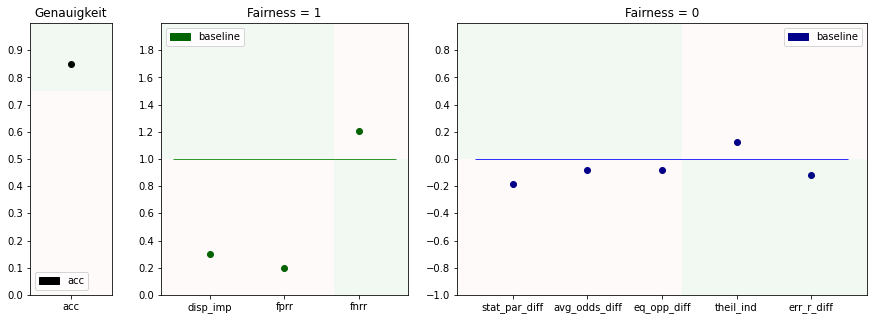

In [40]:
# Visualisieren der Baseline Fairness Ergebnisse
display(Markdown("##### Metrikwerte des Baseline Modells"))
plot_aif_metrics(aif_metrics_baseline)

Um die Bewertung der Ergebnisse intuitiver zu gestalten, wurden die Werte visualisiert. Die linke Grafik zeigt das Ergebnis der Klassifikationsgenauigkeit, die mittlere Grafik visualisiert die Ergebnisse der Metriken mit einem Optimalwert von 1, somit die Disparate Impact Metrik sowie False Positive und False Negative Rate Ratio. Die rechte Grafik zeigt Metriken mit einem optimalen Fairnesswert von 0. Dazu zählen die Statistical Parity, Average Odds und Equal Opportunity Difference, der Theil Index und die Error Rate Difference. Befinden sich die Werte der Fairnessmetriken innerhalb der grünen Bereiche, bedeutet das einen Vorteil für Frauen, der geschützten Gruppe. Werte im hellroten Bereich zeigen einen Vorteil für Männer an, der privilegierten Gruppe. Das Ziel ist das Annähern der Punkte an die Mittellinie, die Kriterien-spezifische Gleichbehandlung signalisiert. 

##### Metrikwerte des Baseline Modells

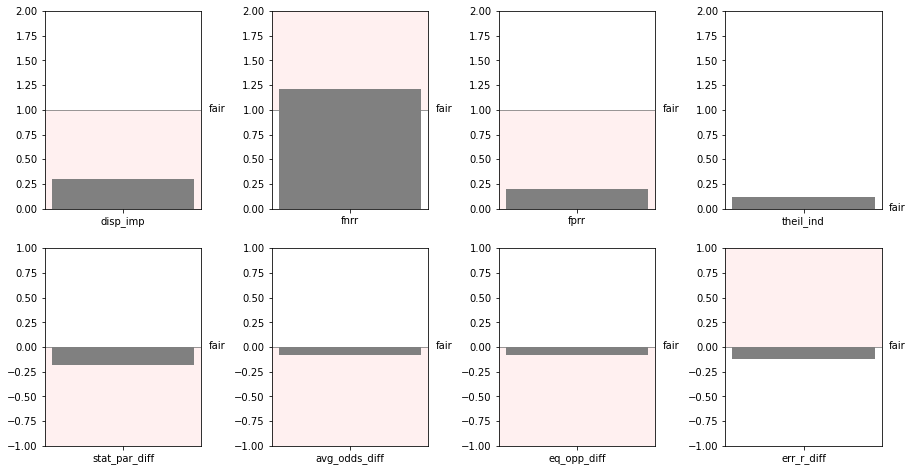

In [41]:
# Visualisieren der einzelnen Metriken als Subplots
display(Markdown("##### Metrikwerte des Baseline Modells"))
fig, ax = plt.subplots(2, 4, figsize=(15,8))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.45, hspace=None)
plot_metric('disp_imp', aif_metrics_baseline['disp_imp'], ax[0,0])
plot_metric('fnrr', aif_metrics_baseline['fnrr'], ax[0,1])
plot_metric('fprr', aif_metrics_baseline['fprr'], ax[0,2])
plot_metric('theil_ind', aif_metrics_baseline['theil_ind'], ax[0,3])
plot_metric('stat_par_diff', aif_metrics_baseline['stat_par_diff'], ax[1,0])
plot_metric('avg_odds_diff', aif_metrics_baseline['avg_odds_diff'], ax[1,1])
plot_metric('eq_opp_diff', aif_metrics_baseline['eq_opp_diff'], ax[1,2])
plot_metric('err_r_diff', aif_metrics_baseline['err_r_diff'], ax[1,3])

#### Evaluierung: Fairness des Baseline Modells

Je weiter der Ergebnisbalken von der Linie entfernt ist, die Fairness signalisiert, desto mehr Voreingenommenheit zeigt das Modell in diesem Bereich. Durch die Ergebnisse der weiteren Fairnessmetriken wird ersichtlich, dass jede der Metriken einen Nachteil für die geschützte Gruppe (Frauen) errechnet, außer die Fehlerratendifferenz. Der Grund dafür könnte, wie anfangs bereits erwähnt, die höhere Repräsentation der Frauen in der Label-Mehrheitsklasse 'income<=50K' sein. 
<br>
Die Disparate Impact Metrik sowie die False Positive Rate Ratio Metrik zeigen die größten Nachteile für die geschützte Gruppe auf. Das bedeutet, dass das Modell dazu tendiert, mehr Männern positive Ergebnisse zuzuschreiben als Frauen (Disparate Impact). und das auch, wenn die Ground Truth den Mann eigentlich als "negativ, 0" eingestuft hat (False Positive Ratio).
<br>
Der Wert für die Equal Opportunity Difference ist bereits relativ nahe an dem Fairnessziel, was bedeutet, dass die True Positive Raten zwischen Männern und Frauen sich nicht allzu sehr unterscheiden, jedoch Männer dennoch häufiger zu recht als positiv eingestuft werden als Frauen. Auch der Wert für die Average Odds Difference, der Mittelwert aus True Positive und False Positive Difference beider Gruppen, ist relativ fair. Dass die Average Odds Difference gering ist, die False Positive Rate jedoch hoch, lässt darauf schließen, dass sich die False Positive Raten der beiden Gruppen absolut gesehen nicht stark unterscheiden, relativ gesehen jedoch schon (und somit für beide Gruppen recht gering sind).
<br>
Laut Theil Index wurde die individuelle Fairness nicht komplett erreicht, ist aber auch nicht sehr weit davon entfernt.

# Techniken zur Milderung von AV

Nach der Evaluierung des Baseline Modells werden nun folgende Techniken zur Abmilderung der erkannten Voreingenommenheit angewandt:

- Pre-Processing:
    - Fairness durch Unbewusstsein
    - Reweighing
- In-Processing:
    - Adversarial Debiasing
- Post-Processing:
    - Reject Option Classification

## Pre-Processing

### Fairness durch Unbewusstsein
Der Ansatz „Fairness durch Unbewusstsein“ hat das Ziel, die Vorhersagen des Modells nicht von dem sensitiven Attribut abhängig zu machen, indem das sensitive Attribut aus dem Datensatz entfernt wird. Grundsätzlich wird diese Methode meist als nicht ausreichend angesehen, da Proxyvariablen das Ergebnis weiterhin beeinflussen können. Die Methode wird in diesem Versuch angewandt, um zu sehen, wie sie im Vergleich zu den gezielten Mitigationsmethoden abschneidet. Hierfür wird die Spalte zum Geschlecht aus dem Datensatz entfernt und das Modell neu trainiert.

In [42]:
X_train.head()  

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,sex,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
27113,-0.261747,-0.035824,-0.439738,-0.147445,-0.218586,-0.077734,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13212,-1.175375,0.030138,-0.439738,-0.147445,-0.218586,-0.077734,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24112,0.042796,-0.012218,1.128918,-0.147445,-0.218586,1.591745,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22502,-0.414018,-0.205997,-0.439738,-0.147445,-0.218586,-0.745526,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3872,-0.870832,0.415804,-0.439738,-0.147445,-0.218586,-0.244682,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
# Entfernen des sensitiven Attributes "sex" aus Training- und Testdaten

X_train_ua = X_train.copy()
X_train_ua = X_train_ua.drop(columns=['sex'])

X_test_ua = X_test.copy()
X_test_ua = X_test_ua.drop(columns=['sex'])  

In [44]:
# Attribut wurde entfernt
X_test_ua.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
217,-0.794697,-1.070313,1.913247,-0.147445,-0.218586,1.174375,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24913,0.195067,-0.107550,-0.439738,-0.147445,-0.218586,-0.077734,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17780,1.108695,0.954520,-0.439738,-0.147445,-0.218586,0.757005,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12484,-0.566290,0.241390,-0.439738,-0.147445,-0.218586,0.339636,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8890,-0.337883,-0.010524,1.128918,-0.147445,-0.218586,-0.077734,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
# Trainieren des gleichen Modells mit den abgewandelten Daten
model_ua = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)  
model_ua.fit(X_train_ua, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [46]:
# Labels für Testdaten vorhersagen
predicted_classes_ua = model_ua.predict(X_test_ua)

In [47]:
accuracy_score(predicted_classes_ua, y_test)

0.8508122444469002

##### Evaluierung

##### Fairness des Baseline Modells

Accuracy:                               85.11%
Disparate Impact:                        0.2995
False Positive Rate Ratio:               0.1989
False Negative Rate Ratio:               1.2062
Statistical Parity Difference:          -0.1832
Equalized/Average odds difference:      -0.0777
Equal opportunity difference:           -0.0788
Theil index:                             0.1233
Error Rate Difference:                  -0.1172


##### Fairness Evaluierung: 'Fairness durch Unbewusstsein'

Accuracy:                               85.08%
Disparate Impact:                        0.3285
False Positive Rate Ratio:               0.2521
False Negative Rate Ratio:               1.1340
Statistical Parity Difference:          -0.1742
Equalized/Average odds difference:      -0.0609
Equal opportunity difference:           -0.0516
Theil index:                             0.1232
Error Rate Difference:                  -0.1156


##### Änderungen der Metrikwerte durch die Methode 'Fairness durch Unbewusstsein'

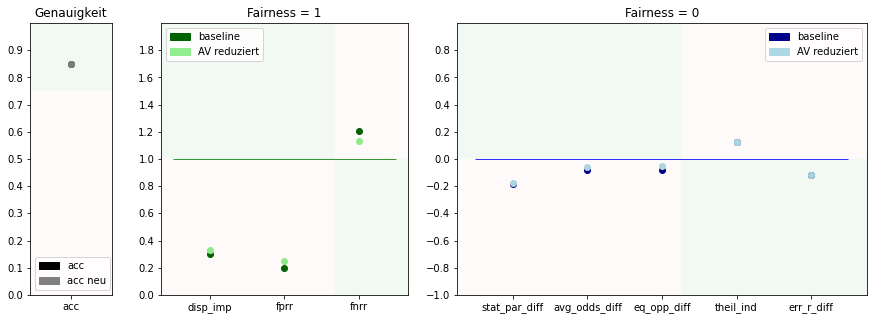

In [48]:
display(Markdown("##### Fairness des Baseline Modells"))
describe_aif_metrics(aif_metrics_baseline)

display(Markdown("##### Fairness Evaluierung: 'Fairness durch Unbewusstsein'"))
aif_metrics_ua = get_aif_metrics(X_aif_test, predicted_classes_ua)
describe_aif_metrics(aif_metrics_ua)

display(Markdown("##### Änderungen der Metrikwerte durch die Methode 'Fairness durch Unbewusstsein'"))
compare_models(aif_metrics_baseline, aif_metrics_ua)

#### Evaluierung: Fairness nach der Methode 'Fairness durch Unbewusstsein'

Das Entfernen der sensitiven Attribute hat die Klassifikationsgenauigkeit kaum beeinflusst. Jedoch hat sich bezüglich der Fairnessmetriken auch nicht viel verändert. Die "größten" Unterschiede zeigen sich in der False Negative Rate Ratio, die sich um ca. 0,072 dem gewünschten Fairnesswert von 1 annäherte. Das bedeutet, dass nun Frauen trotzdem noch häufiger zu Unrecht negativ klassifiziert werden als Männer, jedoch weniger oft als zuvor. Auch die False Positive Rate Ratio wurde um ein kleines Stück fairer, mit einem Wert von 0,252 ist sie jedoch weiterhin weit vom gewünschten Fairnesswert von 1 entfernt. Der Rest der Metrikwerte blieb weitgehend unverändert. <br>
Das Entfernen der sensitiven Attribute ist somit zwar eine schnell zu implementierende Methode, die sich auch kaum auf die Klassifikationsgenauigkeit auswirkt, jedoch sind die Veränderungen in den Fairnesswerten ebenfalls zu gering, um das Modell damit effektiv von Voreingenommenheiten zu befreien. Grund für die Unwirksamkeit dieser Methode sind die enthaltenen Verbindungen und Muster der anderen Variablen, die als Proxyvariablen fungieren und somit indirekt Informationen zu dem sensitiven Attribut enthalten können.

### Reweighing
Bei dieser Pre-Processing Methode werden den Einträgen abhängig von Gruppenzugehörigkeit und Ground Truth Label unterschiedliche Gewichte zugewiesen, um bereits im Datensatz die Fairness zu erhöhen. Dazu wird ein „Reweighing“ Objekt instanziiert, womit der Trainingsdatensatz transformiert werden kann: 

In [49]:
# Trainings-Datensatz transformieren

RW = Reweighing(unprivileged_groups=unprivileged_group,
               privileged_groups=privileged_group)

RW.fit(X_aif_train)

X_aif_train_rw = RW.transform(X_aif_train)

In [50]:
# Neu gewichteten Datensatz mit Disparate Impact und Statistical Parity evaluieren

aif_metric_rw_dataset = BinaryLabelDatasetMetric(X_aif_train_rw, unprivileged_group, privileged_group)
print('Neu gewichteter Datensatz: Disparate Impact:', aif_metric_rw_dataset.disparate_impact())
print('Neu gewichteter Datensatz: Statistical Parity:', aif_metric_rw_dataset.statistical_parity_difference())

Neu gewichteter Datensatz: Disparate Impact: 1.0000000000000002
Neu gewichteter Datensatz: Statistical Parity: 2.7755575615628914e-17


#### Disparate Impact und Statistical Parity

#### Baseline Datensatz (links) - Neu gewichteter Datensatz (rechts)

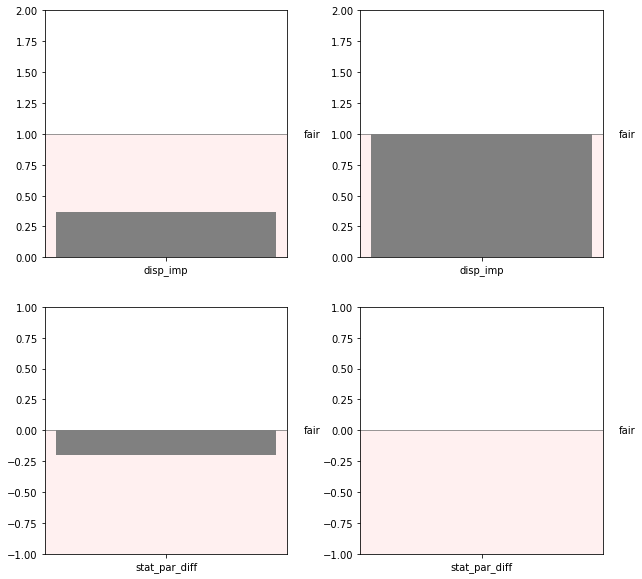

In [51]:
display(Markdown("#### Disparate Impact und Statistical Parity"))
display(Markdown("#### Baseline Datensatz (links) - Neu gewichteter Datensatz (rechts)"))

fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

plot_metric('disp_imp', disparate_impact_baseline_dataset, ax[0,0])
plot_metric('disp_imp', aif_metric_rw_dataset.disparate_impact(), ax[0,1])

plot_metric('stat_par_diff', statistical_parity_baseline_dataset, ax[1,0])
plot_metric('stat_par_diff', aif_metric_rw_dataset.statistical_parity_difference(), ax[1,1])

plt.show()

Die zwei verwendeten Metriken zur Fairness-Evaluierung des Datensatzes zeigen, dass die Verhältnisse an positiven Labels zwischen Frauen und Männern im Trainingsdatensatz nun sehr ausgeglichen sind und der gewichtete Datensatz die beiden Fairnessmetriken erfüllt. Im Folgenden wird die Auswirkung auf die Vorhersagen nach dem Trainieren des Modells mit dem transformierten Datensatz untersucht.

In [52]:
# Erneutes Trainieren des Modells mit dem neu gewichteten Datensatz
model_rw = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)

X_train_rw = X_aif_train_rw.features
y_train_rw = X_aif_train_rw.labels.ravel()

model_rw.fit(X_train_rw, y_train_rw, sample_weight=X_aif_train_rw.instance_weights)  # Gewichte angeben

LogisticRegression(max_iter=1000, random_state=0)

In [53]:
# Modell testen
predicted_classes_rw = model_rw.predict(X_test)

In [54]:
accuracy_score(predicted_classes_rw, y_test)

0.8426345452536191

##### Fairness des Baseline Modells

Accuracy:                               85.11%
Disparate Impact:                        0.2995
False Positive Rate Ratio:               0.1989
False Negative Rate Ratio:               1.2062
Statistical Parity Difference:          -0.1832
Equalized/Average odds difference:      -0.0777
Equal opportunity difference:           -0.0788
Theil index:                             0.1233
Error Rate Difference:                  -0.1172


##### Fairness Evaluierung: 'Reweighing'

Accuracy:                               84.26%
Disparate Impact:                        0.6079
False Positive Rate Ratio:               0.8653
False Negative Rate Ratio:               0.6353
Statistical Parity Difference:          -0.0842
Equalized/Average odds difference:      0.0803
Equal opportunity difference:           0.1694
Theil index:                             0.1355
Error Rate Difference:                  -0.1084


##### Änderungen der Metrikwerte durch die Methode 'Reweighing'

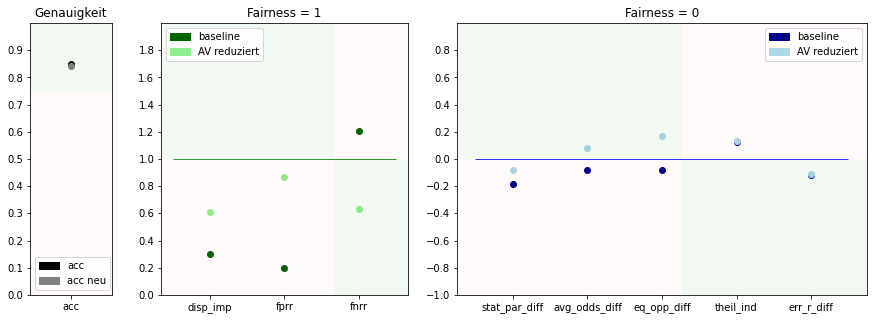

In [55]:
display(Markdown("##### Fairness des Baseline Modells"))
describe_aif_metrics(aif_metrics_baseline)

display(Markdown("##### Fairness Evaluierung: 'Reweighing'"))
aif_metrics_rw = get_aif_metrics(X_aif_test, predicted_classes_rw)
describe_aif_metrics(aif_metrics_rw)

display(Markdown("##### Änderungen der Metrikwerte durch die Methode 'Reweighing'"))
compare_models(aif_metrics_baseline, aif_metrics_rw)

Bei dieser Methode hat sich einiges in den Werten der Fairnessmetriken verändert, wobei die Klassifikationsgenauigkeit nur wenig beeinflusst wurde (-0,85%). Der drastischste Unterschied zeigt sich in der False Positive Rate Ratio. Mit einem Wert von ca. 0,2 wurden im Baseline Modell 5-mal so viele Männer wie Frauen positiv klassifiziert, obwohl sie laut Ground Truth negativ waren. Nach der Neugewichtung des Trainingsdatensatzes stieg der Wert der Metrik auf 0,87, was bedeutet, dass Männer im Vergleich zu Frauen nun "nur noch" 1,16-mal so oft zu Unrecht positiv klassifiziert werden. 
<br><br>
Auch die False Negative Rate Ratio ist um ca. 0,57 gesunken und hat mit ihrem neuen Wert von 0,64 dabei den Fairnesswert von 1 sogar recht deutlich unterschritten. Der Klassifikator wies Männern nun 1,57-mal so oft wie Frauen fälschlicherweise ein negatives Ergebnis zu. 
Damit in Zusammenhang stehend beeinflusst das auch die Ergebnisse zu den True Positive Rates: Das Verhältnis der zu recht positiv klassifizierten Personen ist bei Frauen nun höher als bei Männern, was sich in der Verschiebung der Werte zur Equal Opportunity Difference in einen Bereich abzeichnet, der signalisiert, dass Frauen nun sogar bevorzugt wurden. 
<br>
Die Average Odds Difference, die die Raten zu True Positives und False Positives vereint, verschob sich daraus ableitend somit auch in den "grünen" Bereich. 
<br><br>
Weiterhin nicht allzu hoch bleibt der Wert zur Disparate Impact Metrik, wenn auch er sich stark verbessert hat. Der Wert dieser Metrik hängt jedoch stark von dem zu testenden Datensatz ab und bleibt somit auch niedrig, wenn die Daten auf einem Level individueller Fairness stark unausgeglichen sind.

## IN-PROCESSING

### Adversarial Debiasing
Bei dieser Methode wird neben dem ursprünglichen Klassifikator, dessen Vorhersagegenauigkeit im Training maximiert wird, gleichzeitig ein zusätzliches Modell trainiert, das die Wahrscheinlichkeit reduziert, das geschützte Attribut aus den  Vorhersagen des ersten Klassifikators zu bestimmen. Dieser wird somit fairer, da die Vorhersagen keine Informationen zur Gruppendiskriminierung mehr enthalten, die das zweite Modell ausnutzen kann.

In [56]:
# Diese Methode erfordert das Deaktivieren der "eager execution" von tensorflow und verwendet konfigurierbare "Sessions" für das Training

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
sess = tf.Session()

INFO:tensorflow:Disabling eager execution


Die Implementierung der Adversarial Debiasing Methode in AIF360 erlaubt auch das Trainieren des Baseline-Klassifikators ohne AV-Mitigation. Zunächst wird also auch hier ein Baseline-Modell mit allen spezifischen Einstellungen der implementierten Methode trainiert, um die Fairness-Ergebnisse später besser vergleichbar zu machen. 

In [57]:
# Trainieren des Baseline-Klassifikators mit den definierten Eigenschaften der AIF360 Implementierung

model_baseline_ad = AdversarialDebiasing(privileged_groups = privileged_group,
                          unprivileged_groups = unprivileged_group,
                          scope_name='baseline_model_ad',
                          debias=False,  # keine AV Mitigation
                          sess=sess)

In [58]:
model_baseline_ad.fit(X_aif_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.655850
epoch 1; iter: 0; batch classifier loss: 0.260206
epoch 2; iter: 0; batch classifier loss: 0.323621
epoch 3; iter: 0; batch classifier loss: 0.270233
epoch 4; iter: 0; batch classifier loss: 0.288109
epoch 5; iter: 0; batch classifier loss: 0.306727
epoch 6; iter: 0; batch classifier loss: 0.271660
epoch 7; iter: 0; batch classifier loss: 0.287862
epoch 8; iter: 0; batch classifier loss: 0.342007
epoch 9; iter: 0; batch classifier loss: 0.320762
epoch 10; iter: 0; batch classifier loss: 0.262075
epoch 11; iter: 0; batch classifier loss: 0.272190
epoch 12; iter: 0; batch classifier loss: 0.363749
epoch 13; iter: 0; batch classifier loss: 0.312825
epoch 14; iter: 0; batch classifier loss: 0.234444
epoch 15; iter: 0; batch classifier loss: 0.255082
epoch 16; iter: 0; batch classifier loss: 0.415315
epoch 17; iter: 0; batch cla

In [59]:
# Testen des Baseline Modells
predicted_classes_baseline_ad = model_baseline_ad.predict(X_aif_test)

##### Fairness des Adversarial Debiasing Baseline Modells

Accuracy:                               85.39%
Disparate Impact:                        0.3264
False Positive Rate Ratio:               0.2528
False Negative Rate Ratio:               1.1800
Statistical Parity Difference:          -0.1914
Equalized/Average odds difference:      -0.0712
Equal opportunity difference:           -0.0611
Theil index:                             0.1133
Error Rate Difference:                  -0.1121


##### Neue Metrikwerte des Baseline Models für 'Adversarial Debiasing'

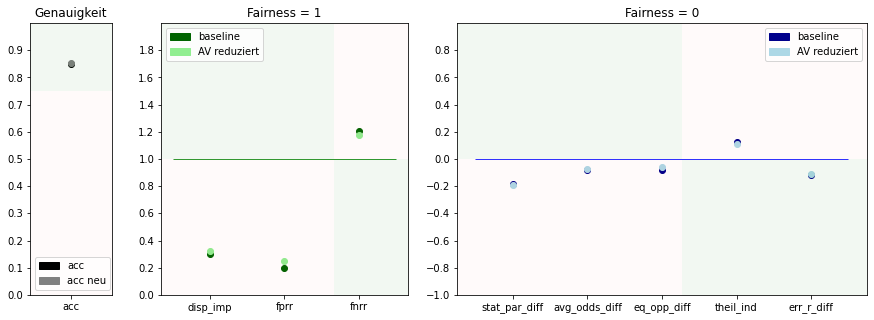

In [60]:
display(Markdown("##### Fairness des Adversarial Debiasing Baseline Modells"))

aif_metrics_ad_baseline = get_aif_metrics(X_aif_test, predicted_classes_baseline_ad.labels)
describe_aif_metrics(aif_metrics_ad_baseline)

# Vergleichen der Fairnessresultate des Adversarial Debiasing Baseline Modells und des eigenen Baseline Modells
display(Markdown("##### Neue Metrikwerte des Baseline Modells für 'Adversarial Debiasing'"))
compare_models(aif_metrics_baseline, aif_metrics_ad_baseline)

Die Fairnesswerte des Baseline "Adversarial Debiasing" Modells unterscheiden sich kaum zu dem eigenen, logistischen Regressions-Baseline Modell von zuvor. Nun wird der gleiche Klassifikator erneut trainiert, diesmal jedoch mit dem gegnerischen Modell zur AV Mitigation.

In [61]:
# neue Session eröffnen
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [62]:
# Erneutes Lernen, diesmal mit dem Parameter 'debias' = True
model_ad = AdversarialDebiasing(privileged_groups = privileged_group,
                          unprivileged_groups = unprivileged_group,
                          scope_name='model_ad',
                          debias=True,
                          sess=sess)

In [63]:
model_ad.fit(X_aif_train)

epoch 0; iter: 0; batch classifier loss: 0.725032; batch adversarial loss: 0.650454
epoch 1; iter: 0; batch classifier loss: 0.413841; batch adversarial loss: 0.602810
epoch 2; iter: 0; batch classifier loss: 0.334356; batch adversarial loss: 0.626587
epoch 3; iter: 0; batch classifier loss: 0.262740; batch adversarial loss: 0.657495
epoch 4; iter: 0; batch classifier loss: 0.364307; batch adversarial loss: 0.590680
epoch 5; iter: 0; batch classifier loss: 0.343612; batch adversarial loss: 0.606603
epoch 6; iter: 0; batch classifier loss: 0.355603; batch adversarial loss: 0.635223
epoch 7; iter: 0; batch classifier loss: 0.370577; batch adversarial loss: 0.660725
epoch 8; iter: 0; batch classifier loss: 0.274361; batch adversarial loss: 0.698311
epoch 9; iter: 0; batch classifier loss: 0.375029; batch adversarial loss: 0.680014
epoch 10; iter: 0; batch classifier loss: 0.458652; batch adversarial loss: 0.646053
epoch 11; iter: 0; batch classifier loss: 0.335042; batch adversarial loss:

In [64]:
# Testen des neuen Modells
predicted_classes_ad = model_ad.predict(X_aif_test)

##### Fairness des Baseline Models

Accuracy:                               85.11%
Disparate Impact:                        0.2995
False Positive Rate Ratio:               0.1989
False Negative Rate Ratio:               1.2062
Statistical Parity Difference:          -0.1832
Equalized/Average odds difference:      -0.0777
Equal opportunity difference:           -0.0788
Theil index:                             0.1233
Error Rate Difference:                  -0.1172


##### Fairness Evaluierung: 'Adversarial Debiasing'

Accuracy:                               84.09%
Disparate Impact:                        0.7504
False Positive Rate Ratio:               1.3933
False Negative Rate Ratio:               0.5161
Statistical Parity Difference:          -0.0433
Equalized/Average odds difference:      0.1375
Equal opportunity difference:           0.2598
Theil index:                             0.1480
Error Rate Difference:                  -0.1176


##### Änderungen der Metrikwerte durch die Methode 'Adversarial Debiasing'

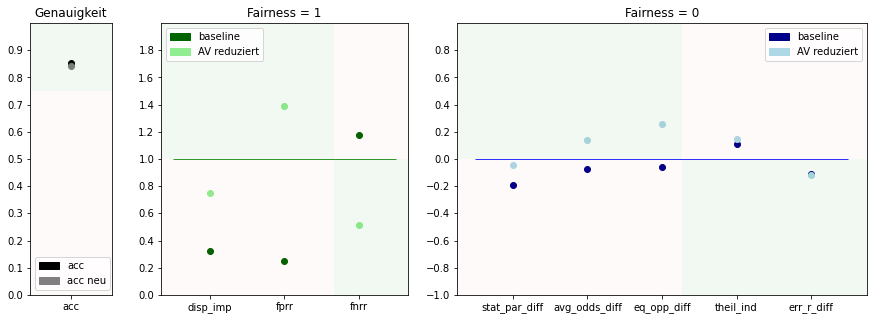

In [65]:
display(Markdown("##### Fairness des Baseline Modells"))
describe_aif_metrics(aif_metrics_baseline)

display(Markdown("##### Fairness Evaluierung: 'Adversarial Debiasing'"))
aif_metrics_ad = get_aif_metrics(X_aif_test, predicted_classes_ad.labels)
describe_aif_metrics(aif_metrics_ad)

# Vergleichen der Fairnessresultate des Adversarial Debiasing Baseline Modells und des neuen AV-reduzierten Modells
display(Markdown("##### Änderungen der Metrikwerte durch die Methode 'Adversarial Debiasing'"))
compare_models(aif_metrics_ad_baseline, aif_metrics_ad)

Auch bei der In-Processing Methode 'Adversarial Debiasing" hat die Klassifikationsgenauigkeit nur geringfügig abgenommen (-1,02%). Ähnlich den Ergebnissen der "Reweighing" Pre-Processing Methode zeigt sich auch hier die größte Veränderung in der False Positive Rate Ratio. Der Wert überschritt das Fairnesslevel 1 und stieg auf 1,4, d.h. nun wurden Frauen ca. 2,5-mal so häufig zu Unrecht positiv klassifiziert wie Männer. 
<br> <br>
Ähnlich verhält es sich mit der False Negative Rate Ratio, sie hat das Fairnesslevel mit einem neuen Wert von 0,52 unterschritten, was nun mehr Vorteile für Frauen bedeutet: Männer werden im Vergleich zu Frauen nun fast 2-mal so oft fälschlicherweise negativ klassifiziert. Durch diese häufigeren Negativ-Werte für Männer stieg nun jedoch auch die Disparate Impact Metrik von 0,3 auf 0,75, was das bisher beste Ergebnis für diese Metrik bedeutet: Das Verhältnis der positiven Vorhersagen zwischen Frauen und Männern ist hier somit am ausgeglichensten (wobei Frauen nach wie vor weniger positive Labels erhielten). Die Statistical Parity Metrik näherte sich ihrem Optimalwert von 0 sehr stark an. 
<br><br>
Ähnlich der 'Reweighing" Methode stiegen auch die Werte für die Average Odds- und Equal Opportunity Metrik an, wobei sie ebenfalls die Fairnessschwelle überschritten, was einen Vorteil für Frauen hinsichtlich der True Positive Rate bedeutet. 
<br><br>
Der Theil Index stieg leicht an, was eine etwas geringere individuelle Fairness bedeutet. Die Fehlerratendifferenz blieb relativ konstant.

## POST-PROCESSING

### Reject Option Cassification
Reject Option Classification ist eine Post-Processing Methode, die mithilfe eines weiteren Validationsdatensatzes und einer gewählten Fairnessmetrik Parameter erlernt, um die Resultate eines bestehenden Modells anzupassen. Da bei dieser Methode ein Validationsdatensatz benötigt wird, um vorhandene Voreingenommenheiten zu erkennen und mit der gewählten Fairnessmetrik abzugleichen, werden für diesen Versuch drei Datensätze benötigt. Der erste wird wie zuvor zum Trainieren des Baseline-Klassifikators verwendet, der zweite zum Erlernen der Fairnesskriterien-spezifischen Parameter für die Anpassung des bestehenden Modells und der dritte letztendlich zum Testen.

In [66]:
# Teilen des Test-Datensatzes in zwei Teile, einen zum "Umtrainieren" (Validation), einer zum Testen (Test)
roc_data_val, roc_data_test = X_aif_test.split([0.5], shuffle=True)

In [67]:
# Index der positiven Klasse
pos_ind = 1

# Baseline Vorhersagen des Valdiation Datensatzes berechnen
predicted_scores_roc_val = roc_data_val.copy(deepcopy=True)  
# Daten und Labels extrahieren
roc_X_val = predicted_scores_roc_val.features 
roc_y_val = predicted_scores_roc_val.labels
predicted_scores_roc_val.scores = model_baseline.predict_proba(roc_X_val)[:,pos_ind].reshape(-1,1) 

Mit den Baseline Vorhersagen und der Ground Truth des Validationsdatensatzes können nun in Verbindung mit einer gewählten Fairnessmetrik die Parameter des Post-Processing Algorithmus angepasst werden. Die AIF360 Implementierung der 'Reject Option Classification' unterstützt die Resultatanpassung anhand drei unterschiedlicher Fairnessmetriken: Statistical Parity Difference, Average Odds Difference und Equal Opportunity Difference. <br>
Die Statistical Parity Metrik wurde zuvor bereits mit der Pre-Processing Methode "Reweighing" optimiert. Beide übrigen Metriken beziehen sich auf die True Positive Rate. Die Average Odds Difference erweitert ihre Fairnesskriterien jedoch zusätzlich um die False Positive Rate und ist somit ein umfassender Indikator für Fairness. Aus diesem Grund wird diese Metrik für die Fairnessoptimierung verwendet. Somit werden die Parameter des Reject Option Classification Objektes anhand dieser Kriterien und den Baseline Ergebnissen der Validationsdaten berechnet.

In [68]:
# Auswahl der Metrik, die für die Optimierung verwendet werden soll
metric_name = "Average odds difference" 

# Fairnessmetrikintervall definieren: Obere und untere Grenze für die verwendete Metrik
metric_ub = 0.05  # 'upper bound'
metric_lb = -0.05  # 'lower bound'

# Schätzung der optimalen ROC Parameter basierend auf der gewählten Metrik
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_group, 
                                 privileged_groups=privileged_group, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,  # Obere und untere Klassifizierungsschwelle, die bei der Optimierung verwendet werden soll
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)

ROC = ROC.fit(roc_data_val, predicted_scores_roc_val)  # "fitting" anhand der Baseline Vorhersagen des Validation Datensatzes

In [69]:
# Baseline Vorhersagen des Test Datensatzes berechnen
predicted_scores_roc_test = roc_data_test.copy(deepcopy=True)
# Daten und Labels extrahieren
roc_X_test = predicted_scores_roc_test.features
roc_y_test = predicted_scores_roc_test.labels

In [70]:
predicted_scores_roc_test.scores = model_baseline.predict_proba(roc_X_test)[:,pos_ind].reshape(-1,1) 

'predicted_scores_roc_test' beinhaltet nun die Testdatensatz-Vorhersagen des voreigenommenen Baseline Modells, die in weiterer Folge durch die Post-Processing Methode transformiert werden.

In [71]:
# Anpassung der Baseline-Vorhersagen mittles ROC
transformed_predicted_scores_roc_test = ROC.predict(predicted_scores_roc_test)  

##### Fairness des Baseline Modells

Accuracy:                               85.11%
Disparate Impact:                        0.2995
False Positive Rate Ratio:               0.1989
False Negative Rate Ratio:               1.2062
Statistical Parity Difference:          -0.1832
Equalized/Average odds difference:      -0.0777
Equal opportunity difference:           -0.0788
Theil index:                             0.1233
Error Rate Difference:                  -0.1172


##### Fairness Evaluierung: 'Reject Option Classification - Average Odds Difference'

Accuracy:                               81.22%
Disparate Impact:                        0.5103
False Positive Rate Ratio:               0.5666
False Negative Rate Ratio:               0.8678
Statistical Parity Difference:          -0.1952
Equalized/Average odds difference:      -0.0335
Equal opportunity difference:           0.0275
Theil index:                             0.0926
Error Rate Difference:                  -0.0848


##### Änderungen der Metrikwerte durch die Methode 'Reject Option Classification - Average Odds Difference'

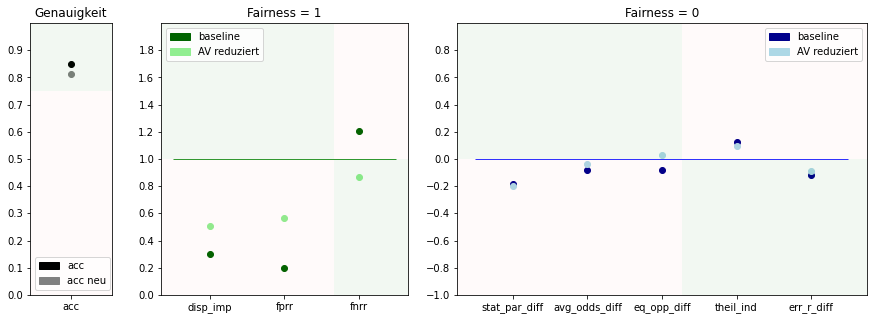

In [72]:
display(Markdown("##### Fairness des Baseline Modells"))
describe_aif_metrics(aif_metrics_baseline)

display(Markdown("##### Fairness Evaluierung: 'Reject Option Classification - Average Odds Difference'"))
aif_metrics_roc = get_aif_metrics(roc_data_test, transformed_predicted_scores_roc_test.labels)
describe_aif_metrics(aif_metrics_roc)

display(Markdown("##### Änderungen der Metrikwerte durch die Methode 'Reject Option Classification - Average Odds Difference'"))
compare_models(aif_metrics_baseline, aif_metrics_roc)

Die Klassifikationsgenauigkeit ist durch die Anwendung der 'Reject Option Classification' Methode mit der 'Average Odds Difference' Metrik auf 81,22% (-3,89%) gesunken, was von allen Mitigationsansätzen somit den größten Verlust an Klassifikationsgenauigkeit bedeutet. Die Average Odds Metrik stieg auf -0,0335 an, verbesserte sich relativ gesehen also um etwa das Doppelte. Wenig überraschend stieg auch die Equal Opportunity Difference an und überschritt dabei sogar leicht das Fairnessziel von 1.  
<br>
Die Metriken Statistical Parity, Theil Index und Error Rate Difference blieben relativ konstant, wobei der Theil Index eine leichte Verbesserung der individuellen Fairness anzeigt.
<br><br>
Anders verhält es sich mit dem Disparate Impact Wert, er stieg auf 0,51 (+0,21) und zeigte somit einen merklichen, im Vergleich zu den anderen AIF360 AV-Mitigationsalgorithmen jedoch dennoch den kleinsten Anstieg. Auch der Anstieg der False Positive Rate um 0,37 fiel im Vergleich zu den anderen Methoden am geringsten aus. Die False Negative Rate kam mit ihrem neuen Wert von 0,87 relativ nahe an das Fairnessziel.

# Vergleich der Mitigationsmethoden und Fazit

### Zusammenfassung
Im Laufe dieses Notebooks wurde ein Klassifikator trainiert, der für Personen vorhersagt, ob sie vermutlich weniger, oder mehr als 50.000$ pro Jahr verdienen. Dabei lag der Fokus auf dem Untersuchen von Voreingenommenheiten bezüglich des sensitiven Attributes Geschlecht. Analysen und Visualisierungen zeigten, dass der Datensatz bereits unausgeglichen und voreingenommen war: Frauen waren unterrepräsentiert und hatten auch seltener ein positives Ground Truth Label. Das Trainieren eines Baseline Modells mit diesen Daten zeigte, dass die Voreingenommenheiten durch das Modell zusätzlich verstärkt wurden.
Im Anschluss wurden folgende Mitigationsmethoden angewendet, um deren Auswirkungen auf die Fairness anhand unterschiedlicher Fairnessdefinitionen (Metriken) zu untersuchen:
- Fairness durch Unbewusstsein (Pre-Processing)
- Reweighing (Pre-Processing)
- Adversarial Debiasing (In-Processing)
- Reject Option Classification (Post-Processing)


### Vergleichen der Ergebnisse aller Mitigationsansätze

In [73]:
# dictionary aller errechneten Metriken erstellen
all_metrics = {}
all_metrics['baseline'] = aif_metrics_baseline
all_metrics['ua'] = aif_metrics_ua
all_metrics['rw'] = aif_metrics_rw
all_metrics['ad'] = aif_metrics_ad
all_metrics['roc'] = aif_metrics_roc

In [74]:
# Methode zum vergleichenden Visualisieren aller Fairnessergebnisse der AV-Mitigationsmethoden

def compare_all_models(all_metrics):
    
    colors = ['grey', 'red', 'blue', 'green', 'orange']
    
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,3,5]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    
    x_coord = 0
    color_index = 0
    patches = []
    for metrics in all_metrics:  # metrics = baseline - ua - rw - ad - roc
        if metrics == 'baseline':
            markersize = 500
        else:
            markersize = 100
        for metric in all_metrics[metrics]:  # metric = acc - disp_imp - (...)
            if metric == 'acc':
                ax0.scatter(metric, all_metrics[metrics][metric], label=metrics, color = colors[color_index], marker='_', s=markersize)
            elif metric == 'disp_imp' or metric == 'fnrr' or metric == 'fprr':
                ax1.scatter(metric, all_metrics[metrics][metric], label=metrics, color = colors[color_index], marker='_', s=markersize)
            else: 
                ax2.scatter(metric, all_metrics[metrics][metric], label=metrics, color = colors[color_index], marker='_', s=markersize)
            x_coord += 1
        patches.append(mpatches.Patch(color=colors[color_index], label=metrics))
        color_index += 1
   
    ax0.set_ylim(0,1)
    ax0.set_title('Genauigkeit')
    ax0.set_yticks(np.arange(0, 1, step=0.1))
    ax0.axhspan(0, 0.75, 0, 1, facecolor='red', alpha=0.02)
    ax0.axhspan(0.75, 1, 0, 1, facecolor='green', alpha=0.05)
    
    ax1.set_ylim(0, 2)
    ax1.set_title('Fairness = 1')
    ax1.set_yticks(np.arange(0, 2, step=0.2))
    ax1.hlines(1, -0.5, 2.5, color='green', linewidth=0.8)
    ax1.axhspan(0, 1, 0, 0.7, facecolor='red', alpha=0.02)
    ax1.axhspan(1, 2, 0, 0.7, facecolor='green', alpha=0.05)
    ax1.axhspan(1, 2, 0.7, 1, facecolor='red', alpha=0.02)
    ax1.axhspan(0, 1, 0.7, 1, facecolor='green', alpha=0.05)
    
    ax2.set_ylim(-1,1)
    ax2.set_title('Fairness = 0')
    ax2.set_yticks(np.arange(-1, 1, step=0.2))
    ax2.hlines(0, -0.5, 4.5, color='blue', linewidth=0.8)
    ax2.axhspan(-1, 0, 0, 0.55, facecolor='red', alpha=0.02)
    ax2.axhspan(0, 1, 0, 0.55, facecolor='green', alpha=0.05)
    ax2.axhspan(0, 1, 0.55, 1, facecolor='red', alpha=0.02)
    ax2.axhspan(-1, 0, 0.55, 1, facecolor='green', alpha=0.05)
    ax2.legend(handles=patches)
    
    plt.show()

## Fairness Evaluierung: Alle Mitigationsmethoden im Vergleich

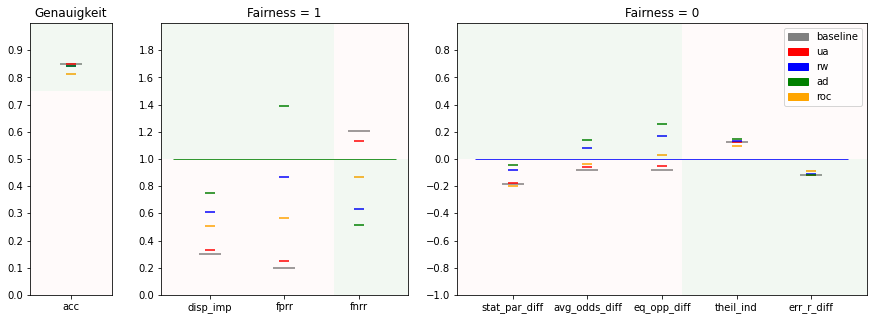

In [75]:
# Visualisieren aller Ergebnisse
display(Markdown("## Fairness Evaluierung: Alle Mitigationsmethoden im Vergleich"))
compare_all_models(all_metrics)

### Fazit
Durch das Analysieren des ursprünglichen Datensatzes wurde klar: Algorithmische Voreingenommenheit ist sehr komplex. Verwendete Attribute in den Daten sind nicht voneinander unabhängig, sondern beeinflussen sich gegenseitig und produzieren somit potenziell ungewollte Muster, die das Modell später aufgreifen kann, wodurch Voreingenommenheiten entstehen können. Das Gewährleisten von Fairness in Machine Learning lässt sich somit nicht auf das Identifizieren und Entfernen von sensitiven Attributen beschränken, wie die Ergebnisse der Mitigationsmethode "Fairness durch Unbewusstsein" zeigte. Die Fairnesswerte veränderten sich nur wenig im Vergleich zu den Ergebnissen des Baseline Modells. <br>
Ein weiteres Problem ist die Vielseitigkeit von möglicher AV. In diesem Experiment wurde nur Fairness bezogen auf das sensitive Attribut Geschlecht betrachtet, aus den Visualisierungen des Datensatzes wurde jedoch ersichtlich, dass auch sehr hohes Diskriminierungspotenzial bezogen auf das Attribut 'race' besteht, eventuell auch auf das (eigentlich nicht zwangsläufig sensitive) Attribut Alter. Diese Akkumulation an möglichen Voreingenommenheiten über verschiedene Untergruppen erschwert das Aufspüren, messbar machen und letztendlich das Abmildern von Voreingenommenheiten. Eine genaue Auseinandersetzung des verwendeten Datensatzes ist somit für die Entwicklung eines fairen KI-Systems unerlässlich. <br>
Die nächste Herausforderung ist die Auswahl der richtigen Fairnessmetriken. Es gibt mittlerweile unzählige Implementierungen der unterschiedlichsten Fairnessdefinitionen: bezogen auf TP-, FP-, TN-, FN-Raten, Differenzen und Verhältnissen, Kombinationen, Fehlerraten, Gruppenfairness, individueller Fairness, Fairness nach Untergruppen, usw. Jede dieser Metriken wird durch verwendete Mitigationsmethoden unterschiedlich stark, manchmal sogar in unterschiedliche Richtungen beeinflusst. Die "wichtigste" Metrik zu wählen, erfordert somit ein ausführliches Auseinandersetzen mit dem Ziel des Systems und den relevantesten Ansprüchen an Fairness. Eine Aufgabe, die viel Zeit und Recherche bedarf, jedoch die Voraussetzung für die passende Wahl des Mitigationsansatzes ist.
<br><br>
Aus diesem Grund lässt sich auch die Frage, welche der Methoden für die besten Fairnessergebnisse gesorgt hat, nicht direkt beantworten. 
<br><br>
Keiner der untersuchten Methoden konnte in allen betrachteten Metriken die besten Ergebnisse erzielen. Die Pre-Processing Methode "Reweighing" sorgte in diesem Anwendungsfall für relativ konstante Verbesserungen über die unterschiedlichen Metriken, ohne dabei die Klassifikationsgenauigkeit stark zu beeinflussen.
<br>
Die In-Processing Methode 'Adversarial Debiasing' bewirkte durch die Bank die größten Veränderungen der Metrikwerte. Das bedeutete jedoch nicht das Erreichen der besten Fairness, da diese Methode oftmals "über das Ziel hinausschoss" und die Voreingenommenheiten sich auf die privilegierte Gruppe verlagerten, etwa bezogen auf die False Positive und False Negative Rate. Mit dieser Methode konnte jedoch der beste Disparate Impact Wert erreicht werden, was bedeutet, dass die positiven Resultate für Frauen und Männer hier am ausgeglichensten ausfielen.
<br>
Die Post-Processing Methode 'Reject Option Classification' mit der Optimierung bezüglich der 'Average Odds Difference' sorgte für die besten Metrikwerte hinsichtlich der Verhältnisse der True Positive Ratens, individueller Fairness und Fehlerraten zwischen den Gruppen. Bezogen auf die Ausgeglichenheit der positiven Ergebnisse und dem Verhältnis der False Positive Raten beider Gruppen waren andere Methoden jedoch besser geeignet. Auch sorgte dieser Algorithmus für die größten Einbußen in der Klassifikationsgenauigkeit.
<br>
Was auffällt ist, dass die individuelle Fairness (gemessen am Theil Index) durch keine der Methoden stark beeinflusst wurde. Der Fokus der verfügbaren Mitigationsmethoden (sowie Metriken) ist somit mehr auf das Erzielen von Gruppenfairness gerichtet. Die größten Unterschiede der Fairnesswerte durch die verwendeten Methoden fanden sich in der False Positive Rate Ratio, also dem Verhältnis der zu Unrecht positiv klassifizierten Fälle beider Gruppen. Auch die False Negative Rate Ratio zeigte sehr unterschiedlich hohe Ergebnisse. Auffällig ist hierbei jedoch, dass alle Ansätze (außer Fairness durch Unbewusstsein) die Voreingenommenheit bezüglich dieser Metrik auf die privilegierte Gruppe rückten. Alle Algorithmen sorgten somit dafür, dass mehr Männer wider der Ground Truth negativ eingeschätzt werden, um daraus die Fairness des Systems bezüglich Frauen zu erhöhen.
<br><br>
Es lässt sich also feststellen: Die Verminderung von Voreingenommenheit ist ein feiner Balanceakt. Die Anwendung eines spezifischen Mitigationsansatzes bedeutet ein gutes Ergebnis einer Fairnessmetrik, während andere Metriken "schlechtere" Werte erzielen. Des Weiteren sorgen unterschiedliche Methoden für ebenso unterschiedlich starke Einbußen in der Klassifikationsgenauigkeit, was je nach Entwicklungsziel und Einsatzbereich des Systems ein entscheidender Faktor für die gewählten Fairnesskriterien sein kann. Mit einem unausgeglichenen oder voreingenommenen Datensatz eine ausgeglichene Modell-Fairness auf allen Ebenen zu erreichen, ist wohl nur sehr schwer möglich.